# Part 2, Topic 2: Voltage Glitching to Bypass Password

---
NOTE: This lab references some (commercial) training material on [ChipWhisperer.io](https://www.ChipWhisperer.io). You can freely execute and use the lab per the open-source license (including using it in your own courses if you distribute similarly), but you must maintain notice about this source location. Consider joining our training course to enjoy the full experience.

---

**SUMMARY:** *We've seen how voltage glitching can be used to corrupt calculations, just like clock glitching. Let's continue on and see if it can also be used to break past a password check.*

**LEARNING OUTCOMES:**

* Applying previous glitch settings to new firmware
* Checking for success and failure when glitching

## Firmware

Again, we've already covered this lab, so it'll be mostly up to you!

In [1]:
SCOPETYPE = 'CWNANO'
PLATFORM = 'CWNANO' #NOT the same as CW308_STM32F3 for voltage glitching!

In [2]:
%%bash -s "$PLATFORM"
cd ../../../hardware/victims/firmware/simpleserial-glitch
make PLATFORM=$1 CRYPTO_TARGET=NONE

SS_VER set to SS_VER_1_1
rm -f -- simpleserial-glitch-CWNANO.hex
rm -f -- simpleserial-glitch-CWNANO.eep
rm -f -- simpleserial-glitch-CWNANO.cof
rm -f -- simpleserial-glitch-CWNANO.elf
rm -f -- simpleserial-glitch-CWNANO.map
rm -f -- simpleserial-glitch-CWNANO.sym
rm -f -- simpleserial-glitch-CWNANO.lss
rm -f -- objdir/*.o
rm -f -- objdir/*.lst
rm -f -- simpleserial-glitch.s simpleserial.s stm32f0_hal_nano.s stm32f0_hal_lowlevel.s
rm -f -- simpleserial-glitch.d simpleserial.d stm32f0_hal_nano.d stm32f0_hal_lowlevel.d
rm -f -- simpleserial-glitch.i simpleserial.i stm32f0_hal_nano.i stm32f0_hal_lowlevel.i
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc.exe (GNU Arm Embedded Toolchain 9-2020-q2-update) 9.3.1 20200408 (release)
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

.
Compiling C: simpleserial-glitch.

In [3]:
%run "../../Setup_Scripts/Setup_Generic.ipynb"

Serial baud rate = 38400
INFO: Found ChipWhisperer😍


In [4]:
fw_path = "../../../hardware/victims/firmware/simpleserial-glitch/simpleserial-glitch-{}.hex".format(PLATFORM)
cw.program_target(scope, prog, fw_path)

Serial baud rate = 115200
Detected known STMF32: STM32F03xx4/03xx6
Extended erase (0x44), this can take ten seconds or more
Attempting to program 4739 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 4739 bytes
Serial baud rate = 38400


In [5]:
scope.io.clkout = 7.5E6
target.baud = 38400*7.5/7.37
def reboot_flush():            
    scope.io.nrst = False
    time.sleep(0.05)
    scope.io.nrst = "high_z"
    time.sleep(0.05)
    #Flush garbage too
    target.flush()

Serial baud rate = 39077.34056987788


In [6]:
#Do glitch loop
reboot_flush()
pw = bytearray([0x74, 0x6F, 0x75, 0x63, 0x68])
target.simpleserial_write('p', pw)

val = target.simpleserial_read_witherrors('r', 1, glitch_timeout=10)#For loop check
valid = val['valid']
if valid:
    response = val['payload']
    raw_serial = val['full_response']
    error_code = val['rv']

print(val)

{'valid': True, 'payload': CWbytearray(b'01'), 'full_response': 'r01\n', 'rv': 1}


In [7]:
import matplotlib.pylab as plt
import chipwhisperer.common.results.glitch as glitch
gc = glitch.GlitchController(groups=["success", "reset", "normal"], parameters=["repeat", "ext_offset"])
gc.display_stats()

IntText(value=0, description='success count:', disabled=True)

IntText(value=0, description='reset count:', disabled=True)

IntText(value=0, description='normal count:', disabled=True)

FloatSlider(value=0.0, continuous_update=False, description='repeat setting:', disabled=True, max=10.0, readou…

FloatSlider(value=0.0, continuous_update=False, description='ext_offset setting:', disabled=True, max=10.0, re…

<IPython.core.display.Javascript object>


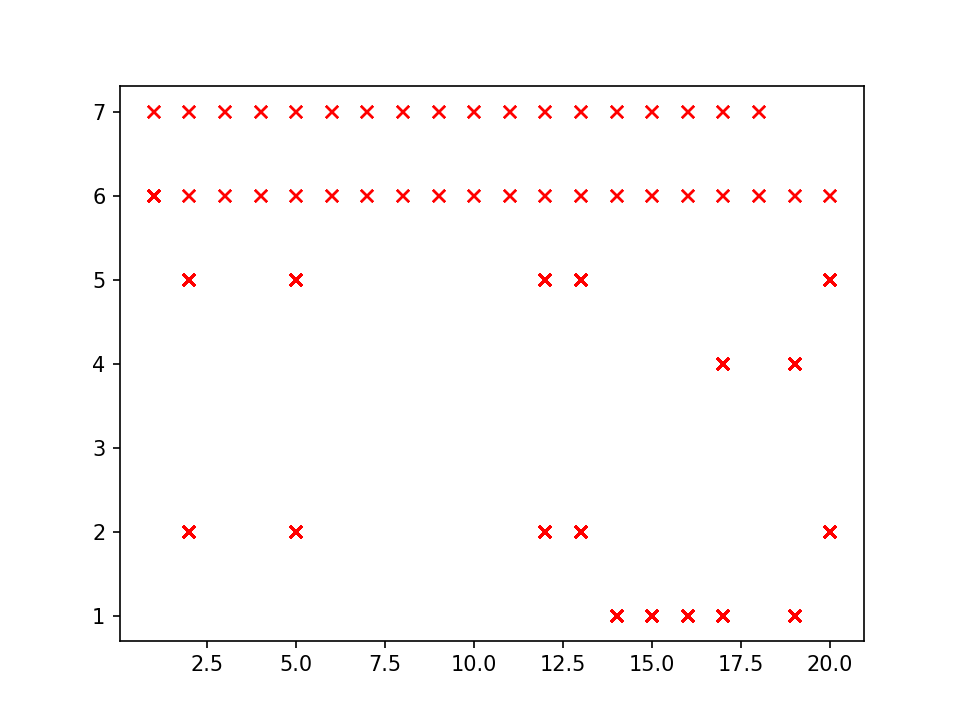

In [8]:
%matplotlib notebook
import matplotlib.pylab as plt
fig = plt.figure()

In [ ]:
from importlib import reload
import chipwhisperer.common.results.glitch as glitch
from tqdm.notebook import tqdm
import re
import struct

g_step = 1

gc.set_global_step(g_step)
gc.set_range("repeat", 1, 7)
gc.set_range("ext_offset", 1, 20)

gc.set_global_step(1)

reboot_flush()
sample_size = 1
scope.glitch.repeat = 0


for glitch_settings in gc.glitch_values():
    scope.glitch.repeat = glitch_settings[0]
    scope.glitch.ext_offset = glitch_settings[1]
    for i in range(50):
        scope.arm()
        target.simpleserial_write('p', bytearray([0]*5))
        ret = scope.capture()

        val = target.simpleserial_read_witherrors('r', 1, glitch_timeout=10)#For loop check
        if ret:
            print('Timeout - no trigger')
            gc.add("reset", (scope.glitch.repeat, scope.glitch.ext_offset))
            plt.plot(scope.glitch.ext_offset, scope.glitch.repeat, 'xr', alpha=1)
            fig.canvas.draw()

            #Device is slow to boot?
            reboot_flush()

        else:
            if val['valid'] is False:
                gc.add("reset", (scope.glitch.repeat, scope.glitch.ext_offset))
                plt.plot(scope.glitch.ext_offset, scope.glitch.repeat, 'xr', alpha=1)
                fig.canvas.draw()
            else:
                if val['rv'] == 1: #for loop check
                    gc.add("success", (scope.glitch.repeat, scope.glitch.ext_offset))
                    print(val)
                    print(val['payload'])
                    print(scope.glitch.repeat, scope.glitch.ext_offset)
                    print("🐙", end="")
                    plt.plot(scope.glitch.ext_offset, scope.glitch.repeat, '+g', alpha=1)
                    fig.canvas.draw()
                else:
                    gc.add("normal", (scope.glitch.repeat, scope.glitch.ext_offset))

In [ ]:
scope.dis()
target.dis()